# CNN

## 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import pickle

from freeman.task.trading.config import *
from freeman.utils.support_tf import LogLevelManager as llm
llm.set(2)

## 데이터 불러오기

In [9]:
with open("/home/freeman/projects/data/trading/data/window_5930.pkl", "rb") as f:
    features, label, date = pickle.load(f)

### 데이터 확인

In [11]:
type(features), features.shape, type(label), label.shape, type(date), date.shape

(numpy.ndarray,
 (1006, 52, 52),
 numpy.ndarray,
 (1006, 1),
 numpy.ndarray,
 (1006, 1))

In [15]:
type(features[0][1][1]), type(label[0][0])

(numpy.float64, numpy.float64)

## 데이터 전처리

### CNN 처리를 위한 채널 추가

In [16]:
features = np.expand_dims(features, -1)
features.shape

(1006, 52, 52, 1)

### 훈련/시험 데이터 분리

In [21]:
TRAIN_RATE = 85
BATCH_SIZE = 32
TRAIN_SIZE = int(features.shape[0] * TRAIN_RATE / 100)

In [31]:
train_x, train_y = features[:TRAIN_SIZE].astype(float), label[:TRAIN_SIZE].astype(float)
test_x, test_y = features[TRAIN_SIZE:].astype(float), label[TRAIN_SIZE:].astype(float)

## CNN 모델 정의

In [32]:
class SimpleCNN(tf.keras.Model):
    
    def __init__(self):
        super(SimpleCNN, self).__init__(name="simple_cnn")
        self.ci = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), 
                                        #  strides=(3,3), padding="same",
                                         activation="relu", input_shape=train_x.shape[1:])
        self.mi = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
        self.c1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), 
                                        #  strides=(3,3), padding="same",
                                         activation="relu")
        self.m1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
        self.c2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), 
                                        #  strides=(3,3), padding="same",
                                         activation="relu")
        self.m2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
        self.f  = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(units=256, activation="relu")
        self.o  = tf.keras.layers.Dense(units=1)
        
    def call(self, inputs):
        l = self.ci(inputs)
        l = self.mi(l)
        l = self.c1(l)
        l = self.m1(l)
        l = self.c2(l)
        l = self.m2(l)
        l = self.f(l)
        l = self.d1(l)
        l = self.o(l)
        return l

In [47]:
cnn = SimpleCNN()
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

## 모델 훈련

In [48]:
%%time
cnn.fit(train_x, train_y, epochs=500, batch_size=32)

Epoch 1/500
27/27 [==============================] - 1s 10ms/step - loss: 0.0382 - mean_absolute_error: 0.1371
Epoch 2/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0565
Epoch 3/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 4/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0456
Epoch 5/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0404
Epoch 6/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_absolute_error: 0.0441
Epoch 7/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_absolute_error: 0.0342
Epoch 8/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_absolute_error: 0.0420
Epoch 9/500
27/27 [==============================] - 0s 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0488
E

## 모델 시험

In [49]:
pred_y = cnn.predict(test_x)

In [50]:
pred_y[1], test_y[1]

(array([0.83499324], dtype=float32), array([0.79010989]))

In [51]:
type(date[TRAIN_SIZE:]), type(date[TRAIN_SIZE:].tolist())

(numpy.ndarray, list)

## 결과 시각화

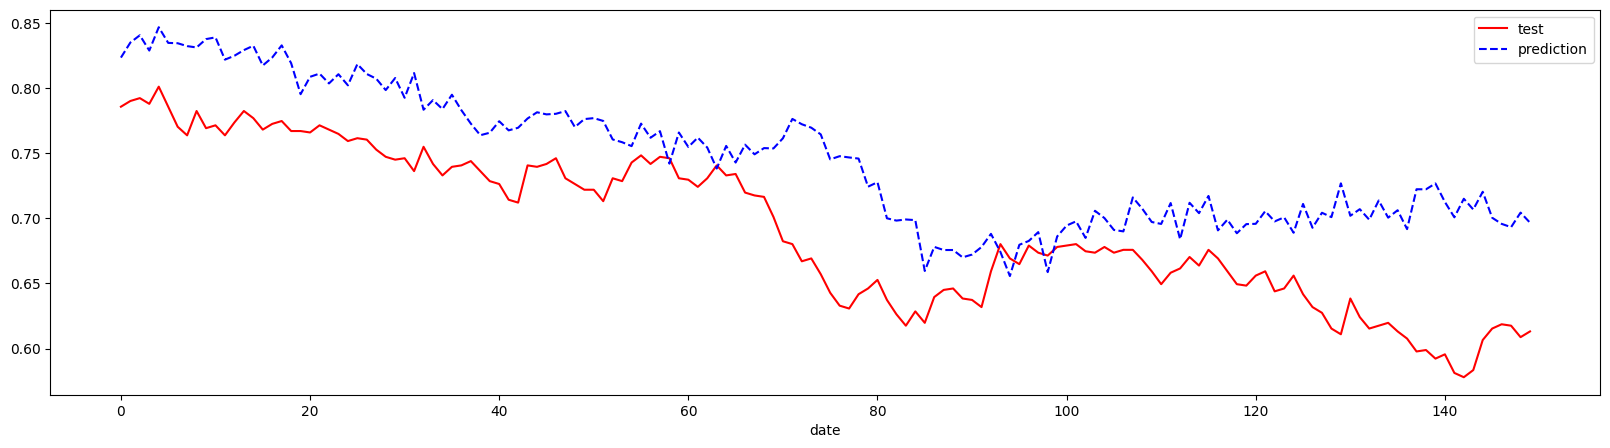

In [52]:
# x = date[TRAIN_SIZE:].tolist()
x = range(len(test_y)-1)
plt.figure(figsize=(20,5))
plt.plot(x, test_y.tolist()[:-1], 'r-', label="test")
plt.plot(x, pred_y.tolist()[:-1], 'b--', label="prediction")
plt.legend()
plt.xlabel('date')
plt.show()